# Analyse Non-Bonded Interactions for All Repeats for ejm 31 Opt Prot

First, need amber input files for the system so we can analyse with Sire. To do this, we need to be careful to construct the openmm system with no constraints and rigidWater==False. Also need to make sure that we used parmed rather than openmm to generate the topology file. Finally, Sire won't give the energy of gromacs input files (will raise an issue) but works fine for amber format files.

In [1]:
pdb_paths = {"complex": [f"../../ejm_31_opt_prot_{n}/ejm_31/complex/system_endstate.pdb" for n in range(1, 6)],
             "solvent": [f"../../ejm_31_opt_prot_{n}/ejm_31/solvent/system_endstate.pdb" for n in range(1, 6)]}

Copy over the system creation functions from run_cor so that we can ensure that there are no constraints/ rigid waters

In [2]:
import parmed
from argparse import ArgumentParser
import numpy as np
import sys
from rdkit import Chem
from openmm.openmm import System
from openmm import unit
from openmm.app import (
    Simulation,
    Topology,
    StateDataReporter,
    ForceField,
    PDBReporter,
    PDBFile,
    HBonds,
    Modeller,
    AmberPrmtopFile,
    AmberInpcrdFile,
    PME,
)
from openff.toolkit.topology import Molecule
from openmmforcefields.generators import SMIRNOFFTemplateGenerator, GAFFTemplateGenerator
from openmmml import MLPotential
from openmm.unit import nanometer, nanometers, molar, angstrom

from openmmtools.openmm_torch.repex import (
    MixedSystemConstructor,
    RepexConstructor,
    MultistateConstructor,
    get_atoms_from_resname,
)
from tempfile import mkstemp
import os


def initialize_mm_forcefield(molecule):
    forcefield = ForceField("amber/protein.ff14SB.xml",
                            "amber/tip3p_standard.xml")
    if molecule is not None:
        # Ensure we use unconstrained force field

        # OFF 1.0.0
        smirnoff = SMIRNOFFTemplateGenerator(
            molecules=molecule, forcefield='openff_unconstrained-1.0.0.offxml')
        forcefield.registerTemplateGenerator(smirnoff.generator)

        # Gaff
        #gaff = GAFFTemplateGenerator(molecules=molecule, forcefield='gaff-2.11')
        # forcefield.registerTemplateGenerator(gaff.generator)

    return forcefield


def get_lig_idx(name, file):
    """Get ligand index from sdf file"""
    ligs = []
    with open(file) as f:
        for l in f:
            if l.startswith("lig"):
                ligs.append(l[4:-1])  # Remove lig and \n

    return ligs.index(name)


def get_lig_smiles(sdf_file, idx):
    """Get smiles of mol from sdf file"""
    sdfs = Chem.SDMolSupplier(sdf_file)
    smiles = Chem.MolToSmiles(sdfs[idx])
    return smiles
    

def create_mm_system_from_scratch(lig_name, pdb_path, sdfs_path):
    """Run MM->ANI corrections for a single ligand in complex or solvent leg

    Args:
        lig_name (str): Name of ligand in form "emj_31".
        pdb_path (str): Path to pdb file which will be used for parametrisation.
        sdfs_path (str): Path to file containing all ligand sdfs.

    Returns:
        system: OpenMM system object
    """
    # Get smiles of ligand
    idx = get_lig_idx(lig_name, sdfs_path)
    smiles = get_lig_smiles(sdfs_path, idx)

    # Get ligand Molecule object
    molecule = Molecule.from_smiles(smiles)

    # Create forcefield
    forcefield = initialize_mm_forcefield(molecule)

    # Create mm system
    input_file = PDBFile(pdb_path)
    modeller = Modeller(input_file.topology, input_file.positions)
    mm_system = forcefield.createSystem(
        modeller.topology,
        nonbondedMethod=PME,
        # These options are key for being able to convert to other systems.
        constraints=None,
        rigidWater=False)

    return mm_system

/home/finlayclark/anaconda3/envs/mamba/envs/omm-beta-changed/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/finlayclark/anaconda3/envs/mamba/envs/omm-beta-changed/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/finlayclark/anaconda3/envs/mamba/envs/omm-beta-changed/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/finlayclark/anaconda3/envs/mamba/envs/omm-beta-changed/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  retur

Now save the gromacs output for each leg for each run

In [3]:
for leg in ["complex", "solvent"]:
    for run_no in range(0,5):
        print(f"Creating files for {leg} run {run_no + 1}")
        print('     Reading the PDB file')
        pdb = parmed.load_file(pdb_paths[leg][run_no])

        print('     Creating the system')
        omm_system = create_mm_system_from_scratch("ejm_31", pdb_paths[leg][run_no], "../../ligands.sdf")

        print('     Creating a structure from the OpenMM objects')
        pmd_structure = parmed.openmm.load_topology(pdb.topology, system=omm_system, xyz=pdb.positions)

        print('     Saving AMBER files')
        save_path = pdb_paths[leg][run_no].replace(".pdb", "")
        pmd_structure.save(f"{save_path}.rst7", overwrite=True)
        pmd_structure.save(f"{save_path}.prmtop", overwrite=True)

Creating files for complex run 1
     Reading the PDB file
     Creating the system


     Creating a structure from the OpenMM objects
     Saving GROMACS files
Creating files for complex run 2
     Reading the PDB file
     Creating the system
     Creating a structure from the OpenMM objects
     Saving GROMACS files
Creating files for complex run 3
     Reading the PDB file
     Creating the system
     Creating a structure from the OpenMM objects
     Saving GROMACS files
Creating files for complex run 4
     Reading the PDB file
     Creating the system
     Creating a structure from the OpenMM objects
     Saving GROMACS files
Creating files for complex run 5
     Reading the PDB file
     Creating the system
     Creating a structure from the OpenMM objects
     Saving GROMACS files
Creating files for solvent run 1
     Reading the PDB file
     Creating the system
     Creating a structure from the OpenMM objects
     Saving GROMACS files
Creating files for solvent run 2
     Reading the PDB file
     Creating the system
     Creating a structure from the OpenM

## Centre the Trajectories

At this point, switched to different python environment with the latest BSS installed from the openbiosim channel (comes with Sire).

Now we centre the trajectories with MDAnalysis to avoid issues with calculated energies when the ligand is near the periodic boundary.

In [ ]:
import MDAnalysis as mda
from MDAnalysis import transformations as trans

In [ ]:
input_paths = {"complex": [f"../../ejm_31_opt_prot_{n}/ejm_31/complex/" for n in range(1, 6)],
             "solvent": [f"../../ejm_31_opt_prot_{n}/ejm_31/solvent/" for n in range(1, 6)]}

In [ ]:
def centre_traj(universe, selection):
    """Centres trajectory on selection"""

    molecules = universe.select_atoms(f'{selection}')
    print(f"N atoms in selected molecule: {molecules.n_atoms}")
    not_molecules = universe.select_atoms(f'not {selection}')
    transforms = [#trans.unwrap(molecules),
                trans.center_in_box(molecules, wrap=True),
                trans.wrap(not_molecules)]
    universe.trajectory.add_transformations(*transforms)
    return universe

def save_centred_traj(input_files, selection, save_path):
    """Centres trajectory on selection and saves"""
    universe = mda.Universe(input_files[0], input_files[1])
    universe = centre_traj(universe, selection)
    with mda.Writer(save_path, universe.atoms.n_atoms) as W:
        for ts in universe.trajectory:
            W.write(universe)

In [ ]:
# Centre all trajs
for leg in ["complex", "solvent"]:
    for run_no in range(0,5):
        for state in range(0, 5):
            print(f"Saving centred traj for {leg} run {run_no + 1} state {state}")
            save_centred_traj([f"{input_paths[leg][run_no]}/system_endstate.prmtop", 
                               f"{input_paths[leg][run_no]}/traj_state{state}.dcd"], 
                               "resname MOL", 
                               f"{input_paths[leg][run_no]}/traj_state{state}_centred.dcd" )

Saving centred traj for complex run 1 state 0
N atoms in selected molecule: 4702
Saving centred traj for complex run 1 state 1
N atoms in selected molecule: 4702
Saving centred traj for complex run 1 state 2
N atoms in selected molecule: 4702
Saving centred traj for complex run 1 state 3
N atoms in selected molecule: 4702
Saving centred traj for complex run 1 state 4
N atoms in selected molecule: 4702
Saving centred traj for complex run 2 state 0
N atoms in selected molecule: 4702
Saving centred traj for complex run 2 state 1
N atoms in selected molecule: 4702
Saving centred traj for complex run 2 state 2
N atoms in selected molecule: 4702
Saving centred traj for complex run 2 state 3
N atoms in selected molecule: 4702
Saving centred traj for complex run 2 state 4
N atoms in selected molecule: 4702
Saving centred traj for complex run 3 state 0
N atoms in selected molecule: 4702
Saving centred traj for complex run 3 state 1
N atoms in selected molecule: 4702
Saving centred traj for comp

## Analyse the Trajectories

Qustions to answer:

 - To build some intuition for the system, what are the most important protein-ligand interactions?
 - How do the average energies change between lambda windows, on a component-wise basis?

In [1]:
import sire as sr
import os
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

### What are the most important protein-ligand interactions? 

In [15]:
amber_files_run_1_com = [os.path.join(input_paths["complex"][0], ext) for ext in ["system_endstate.prmtop", "system_endstate.rst7"]]
com_sys = sr.load(amber_files_run_1_com)

In [16]:
lig = com_sys["MOL"]
lig.view()

NGLWidget()

In [17]:
lig.energy().components()

{'dihedral': 9.85444 kcal mol-1,
 '1-4_LJ': 11.4414 kcal mol-1,
 'intra_LJ': -0.829384 kcal mol-1,
 'angle': 149.72 kcal mol-1,
 'intra_coulomb': 224.187 kcal mol-1,
 'bond': 0.628388 kcal mol-1,
 '1-4_coulomb': -429.033 kcal mol-1}

In [18]:
sr.search.set_token("lig", "count(atoms) > 1 and not (protein or water)")

In [19]:
residues = com_sys["(residues within 3 of lig) and protein"]
residues

Selector<SireMol::Residue>( size=14
0:  Residue( LEU:15  num_atoms=19 )
1:  Residue( GLU:17  num_atoms=15 )
2:  Residue( VAL:23  num_atoms=16 )
3:  Residue( ALA:40  num_atoms=10 )
4:  Residue( ILE:72  num_atoms=19 )
...
9:  Residue( GLY:96  num_atoms=7 )
10:  Residue( ASN:140 num_atoms=14 )
11:  Residue( LEU:142 num_atoms=19 )
12:  Residue( GLY:152 num_atoms=7 )
13:  Residue( ASP:153 num_atoms=12 )
)

In [20]:
com_sys["((residues within 3 of lig) and protein) or lig"].view()

NGLWidget()

In [21]:
data = {"residue": [], "component": [], "energy": []}

for residue in residues:
    # get the name and number of each residue as an ID
    resid = f"{residue.name().value()}:{residue.number().value()}"
    
    # calculate the energy between this residue and the ligand
    energy = residue.energy(lig)
    
    # now save the components of this residue into the dictionary above...
    for component in energy.components():
        data["residue"].append(resid)
        data["component"].append(component)
        data["energy"].append(energy[component].to(sr.units.kcal_per_mol))

    # also save the total energy into the dictionary
    data["residue"].append(resid)
    data["component"].append("total")
    data["energy"].append(energy.to(sr.units.kcal_per_mol))

In [22]:
import pandas as pd
df = pd.DataFrame.from_dict(data)

<Axes: xlabel='residue'>

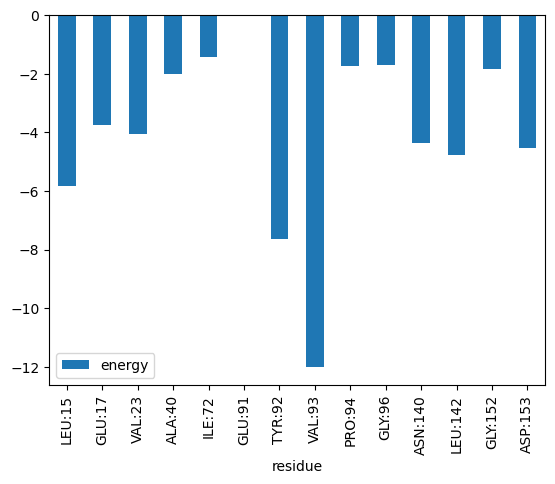

In [30]:
df[ df["component"] == "total" ].plot.bar(x="residue")

<Axes: xlabel='residue'>

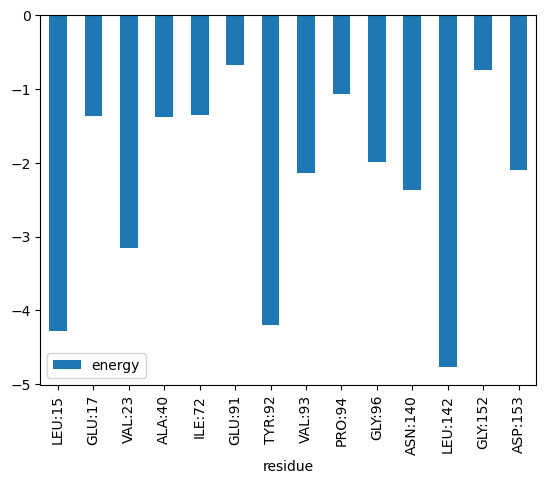

In [24]:
df[ df["component"] == "LJ" ].plot.bar(x="residue")

<Axes: xlabel='residue'>

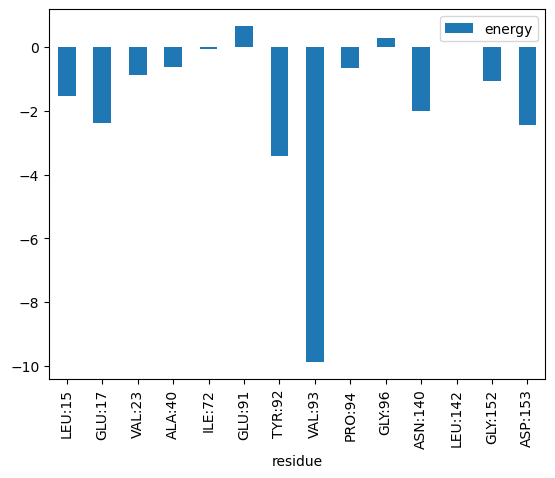

In [25]:
df[ df["component"] == "coulomb" ].plot.bar(x="residue")

In [26]:
# View the three residues with the strongest interactions with the ligand
com_sys["lig or (resname VAL and resnum 93) or (resname TYR and resnum 92) or (resname LEU and resnum 15)"].view()

NGLWidget()

### How do the average energies change between lambda windows?

In [5]:
intra_components = ['1-4_LJ', '1-4_coulomb', 'angle', 'bond', 'dihedral', 'intra_LJ', 'intra_coulomb', 'total']
inter_components = ['LJ', 'coulomb', 'total']
color_array = ["264653","2a9d8f","e9c46a","f4a261","e76f51"]

def get_energy_df(energy_type, system):
    """Get the energy components over a trajectory for either
    the intermolecular (lig - system) or intramolecular interactions

    Args:
        energy_type (str): Type of energy to get average of - either "intra" or "inter"
        system (sire.system.System): System to get energy from, which must have
            been created from a trajectory.

    Returns:
        pandas.core.frame.DataFrame: Dataframe containing energy components over trajectory. 
    """
    if energy_type == "inter":
        return system["MOL"].trajectory().energy(system["not resname MOL"])
    elif energy_type == "intra":
        return system["MOL"].trajectory().energy()


def get_energy_dfs(energy_type, base_paths, n_runs=5, n_states=5):
    """Get the energy components over a trajectory for either
    the intermolecular (lig - system) or intramolecular interactions

    Args:
        energy_type (str): Type of energy to get average of - either "intra" or "inter"
        base_paths (list): List of paths to the base directories for each run.
        n_runs (int, optional): Number of runs to get energies for. Defaults to 5.
        n_states (int, optional): Number of states to get energies for. Defaults to 5.

    Returns:
        dict: Dictionary containing pandas dataframes of the energy components over trajectory for each run and state.
    """
    energy_dfs = {}
    for run in range(1, n_runs + 1):
        energy_dfs[run] = {}
        for state in range(n_states):
            print(f"Getting energies for run {run} state {state}")
            input_files = [os.path.join(base_paths[run - 1], ext) for ext in \
                            ["system_endstate.prmtop", f"traj_state{state}_centred.dcd"]]
            system = sr.load(input_files)
            energy_dfs[run][state] = get_energy_df(energy_type, system)

    return energy_dfs


def plot_av_energy_component(energy_dfs, component, ax, average_over_runs=False):
    """ 
    Plot the energy component averaged over the trajectory.

    Args:
        energy_dfs (dict): Dictionary of energy dataframes for each run and state.
        component (str): Name of energy component to plot.
        ax (matplotlib.axes._subplots.AxesSubplot): Axes to plot on.
        average_over_runs (bool, optional): Whether to average over runs. Defaults to False.
    """
    if average_over_runs:
        mean_state_energies = []
        mean_state_sems = []
        for state in energy_dfs[1]:
            state_energies = []
            for run in energy_dfs:
                state_energies.append(energy_dfs[run][state][component].mean())
            mean_state_energies.append(np.mean(state_energies))
            mean_state_sems.append(np.std(state_energies) / np.sqrt(len(state_energies)))

        ax.bar(range(len(mean_state_energies)), mean_state_energies, yerr=mean_state_sems, 
               color=[f"#{color}" for color in color_array])
        ax.set_xlabel("State")

        # Set reasonable y limits
        ax.set_ylim([min(mean_state_energies) - max(mean_state_sems), max(mean_state_energies) + max(mean_state_sems)])

    else:
        runs = [f"run {run}" for run in energy_dfs]
        energy_means_at_state = {state: [] for state in energy_dfs[1]}
        for run in energy_dfs:
            for state in energy_dfs[run]:
                energy_means_at_state[state].append(energy_dfs[run][state][component].mean())

        x = np.arange(len(runs))  # the label locations
        width = 0.12  # the width of the bars
        multiplier = 0

        for state, mean_energy in energy_means_at_state.items():
            offset = width * multiplier
            rects = ax.bar(x + offset, mean_energy, width, label=f"State {state}", color=f"#{color_array[state]}")
            multiplier += 1

        # Set reasonable y limits by finding smallest and largest mean energies
        max_e = -10000
        min_e = 10000
        for state in energy_means_at_state:
            if max(energy_means_at_state[state]) > max_e:
                max_e = max(energy_means_at_state[state])
            if min(energy_means_at_state[state]) < min_e:
                min_e = min(energy_means_at_state[state])
        ax.set_ylim([min_e - 0.1, max_e + 0.1])

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_xticks(x + width, runs)
        ax.legend()

    ax.set_ylabel(f"Mean {component} energy (kcal/mol)")
    ax.set_title(f"Mean {component} energy over trajectory")

def plot_av_energy_components(energy_dfs, components, energy_type, leg, average_over_runs=False):
    """Plot the energy components averaged over the trajectory.

    Args:
        energy_dfs (dict): Dictionary of energy dataframes for each run and state.
        components (list): List of energy components to plot.
        energy_type (str): Type of energy to plot - either "intra" or "inter". Used to label the plot.
        leg (str): "solvent" or "complex" to label the plot.
        average_over_runs (bool, optional): Whether to average over runs. Defaults to False.
    """
    n_components = len(components)
    n_rows = ceil(n_components / 4)
    fig, axs = plt.subplots(n_rows, 4, figsize=(20, 4 * n_rows))
    for i, component in enumerate(components):
        plot_av_energy_component(energy_dfs, component, axs.flat[i], average_over_runs=average_over_runs)

    title = f"Mean {energy_type} energy components for {leg} leg"
    if average_over_runs:
        title += " (averaged over runs)"
    fig.suptitle(title) 
    fig.tight_layout()
    fig.show()
    if average_over_runs:
        save_title = f"mean_{energy_type}_energy_components_{leg}_leg_averaged_over_runs.png"
    else:
        save_title = f"mean_{energy_type}_energy_components_{leg}_leg.png"
    fig.savefig(save_title)


In [6]:
# Get all the energy dfs
energy_dfs_free_intra = get_energy_dfs("intra", input_paths["solvent"])
energy_dfs_free_inter = get_energy_dfs("inter", input_paths["solvent"])
energy_dfs_bound_intra = get_energy_dfs("intra", input_paths["complex"])
energy_dfs_bound_inter = get_energy_dfs("inter", input_paths["complex"])

Getting energies for run 1 state 0


INFO:rdkit:Enabling RDKit 2022.09.1 jupyter extensions


Output()

INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Getting energies for run 1 state 1


Output()

Getting energies for run 1 state 2


Output()

Getting energies for run 1 state 3


Output()

Getting energies for run 1 state 4


Output()

Getting energies for run 2 state 0


Output()

Getting energies for run 2 state 1


Output()

Getting energies for run 2 state 2


Output()

Getting energies for run 2 state 3


Output()

Getting energies for run 2 state 4


Output()

Getting energies for run 3 state 0


Output()

Getting energies for run 3 state 1


Output()

Getting energies for run 3 state 2


Output()

Getting energies for run 3 state 3


Output()

Getting energies for run 3 state 4


Output()

Getting energies for run 4 state 0


Output()

Getting energies for run 4 state 1


Output()

Getting energies for run 4 state 2


Output()

Getting energies for run 4 state 3


Output()

Getting energies for run 4 state 4


Output()

Getting energies for run 5 state 0


Output()

Getting energies for run 5 state 1


Output()

Getting energies for run 5 state 2


Output()

Getting energies for run 5 state 3


Output()

Getting energies for run 5 state 4


Output()

Getting energies for run 1 state 0


Output()

Getting energies for run 1 state 1


Output()

Getting energies for run 1 state 2


Output()

Getting energies for run 1 state 3


Output()

Getting energies for run 1 state 4


Output()

Getting energies for run 2 state 0


Output()

Getting energies for run 2 state 1


Output()

Getting energies for run 2 state 2


Output()

Getting energies for run 2 state 3


Output()

Getting energies for run 2 state 4


Output()

Getting energies for run 3 state 0


Output()

Getting energies for run 3 state 1


Output()

Getting energies for run 3 state 2


Output()

Getting energies for run 3 state 3


Output()

Getting energies for run 3 state 4


Output()

Getting energies for run 4 state 0


Output()

Getting energies for run 4 state 1


Output()

Getting energies for run 4 state 2


Output()

Getting energies for run 4 state 3


Output()

Getting energies for run 4 state 4


Output()

Getting energies for run 5 state 0


Output()

Getting energies for run 5 state 1


Output()

Getting energies for run 5 state 2


Output()

Getting energies for run 5 state 3


Output()

Getting energies for run 5 state 4


Output()

Getting energies for run 1 state 0


Output()

Getting energies for run 1 state 1


Output()

Getting energies for run 1 state 2


Output()

Getting energies for run 1 state 3


Output()

Getting energies for run 1 state 4


Output()

Getting energies for run 2 state 0


Output()

Getting energies for run 2 state 1


Output()

Getting energies for run 2 state 2


Output()

Getting energies for run 2 state 3


Output()

Getting energies for run 2 state 4


Output()

Getting energies for run 3 state 0


Output()

Getting energies for run 3 state 1


Output()

Getting energies for run 3 state 2


Output()

Getting energies for run 3 state 3


Output()

Getting energies for run 3 state 4


Output()

Getting energies for run 4 state 0


Output()

Getting energies for run 4 state 1


Output()

Getting energies for run 4 state 2


Output()

Getting energies for run 4 state 3


Output()

Getting energies for run 4 state 4


Output()

Getting energies for run 5 state 0


Output()

Getting energies for run 5 state 1


Output()

Getting energies for run 5 state 2


Output()

Getting energies for run 5 state 3


Output()

Getting energies for run 5 state 4


Output()

Getting energies for run 1 state 0


Output()

Getting energies for run 1 state 1


Output()

Getting energies for run 1 state 2


Output()

Getting energies for run 1 state 3


Output()

Getting energies for run 1 state 4


Output()

Getting energies for run 2 state 0


Output()

Getting energies for run 2 state 1


Output()

Getting energies for run 2 state 2


Output()

Getting energies for run 2 state 3


Output()

Getting energies for run 2 state 4


Output()

Getting energies for run 3 state 0


Output()

Getting energies for run 3 state 1


Output()

Getting energies for run 3 state 2


Output()

Getting energies for run 3 state 3


Output()

Getting energies for run 3 state 4


Output()

Getting energies for run 4 state 0


Output()

Getting energies for run 4 state 1


Output()

Getting energies for run 4 state 2


Output()

Getting energies for run 4 state 3


Output()

Getting energies for run 4 state 4


Output()

Getting energies for run 5 state 0


Output()

Getting energies for run 5 state 1


Output()

Getting energies for run 5 state 2


Output()

Getting energies for run 5 state 3


Output()

Getting energies for run 5 state 4


Output()

#### Free Leg - Intramolecular Energies

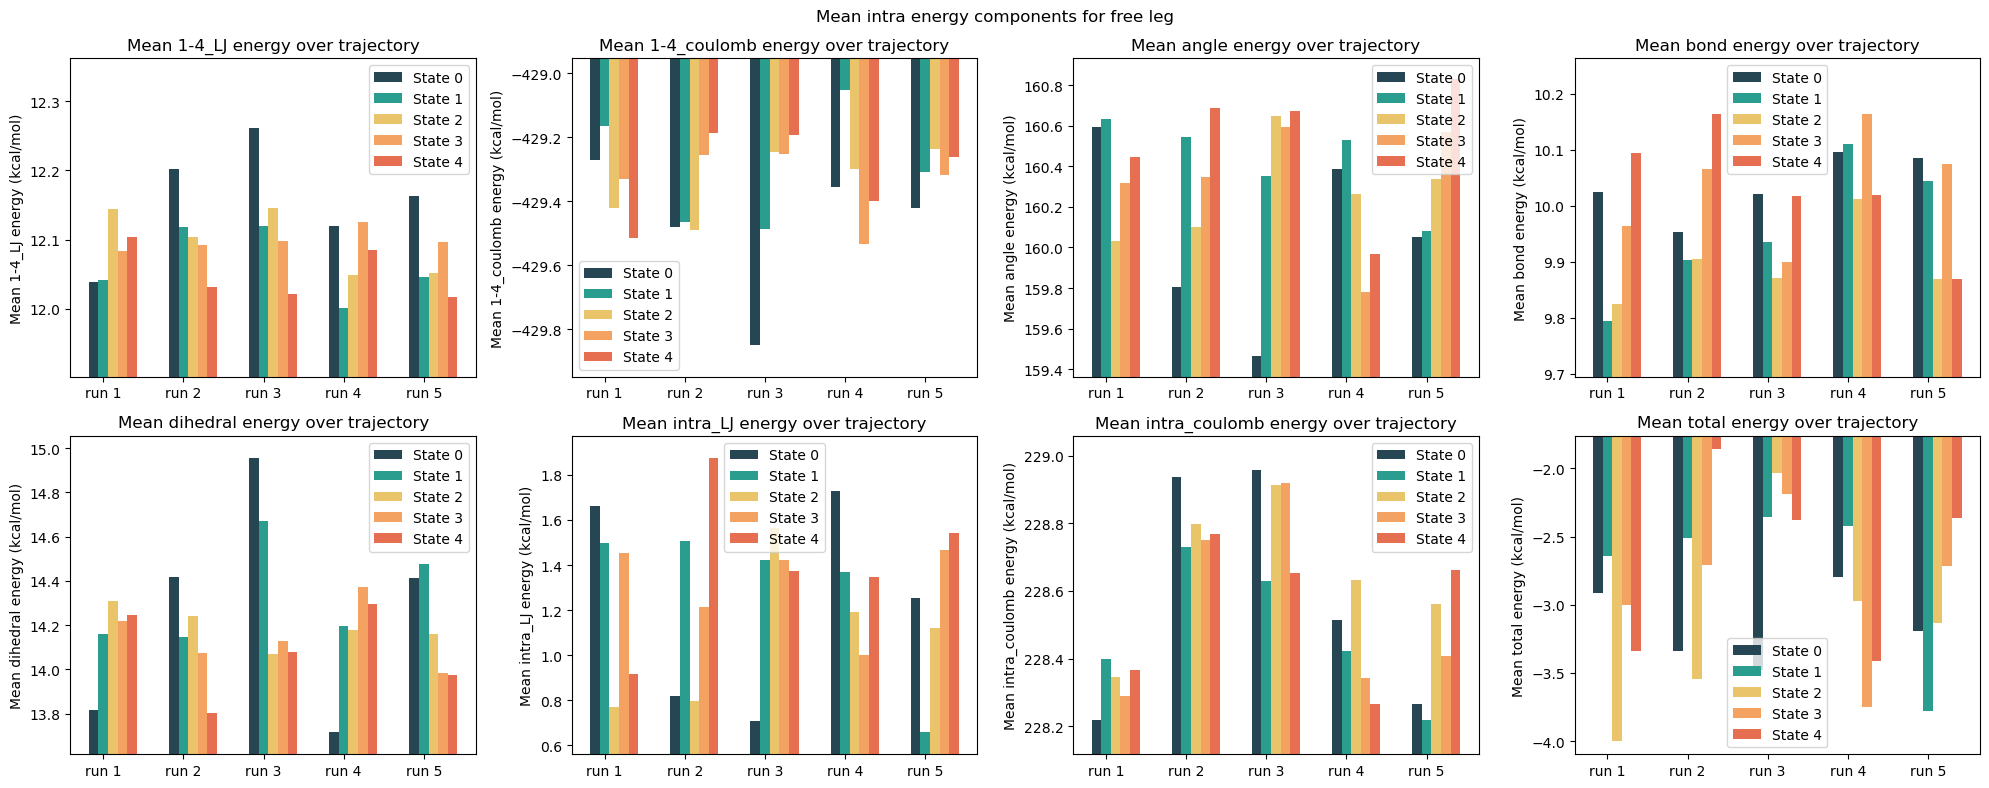

In [7]:
plot_av_energy_components(energy_dfs_free_intra, intra_components, "intra", "free", average_over_runs=False)

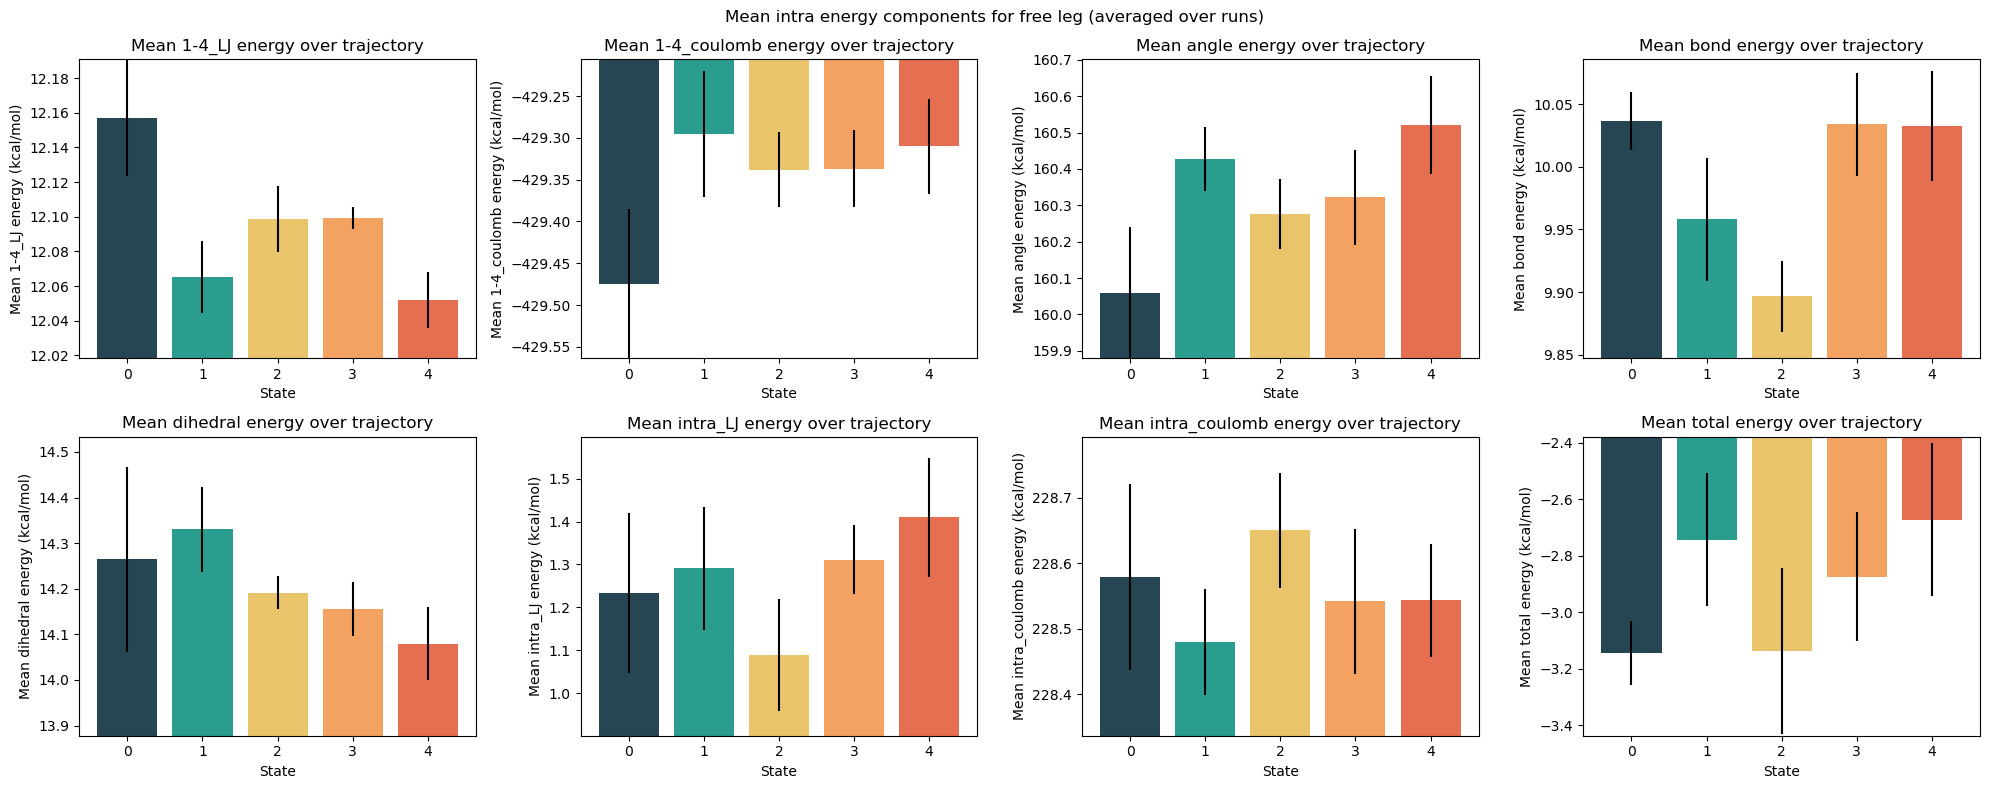

In [8]:
plot_av_energy_components(energy_dfs_free_intra, intra_components, "intra", "free", average_over_runs=True)

#### Free Leg - Intermolecular Energies

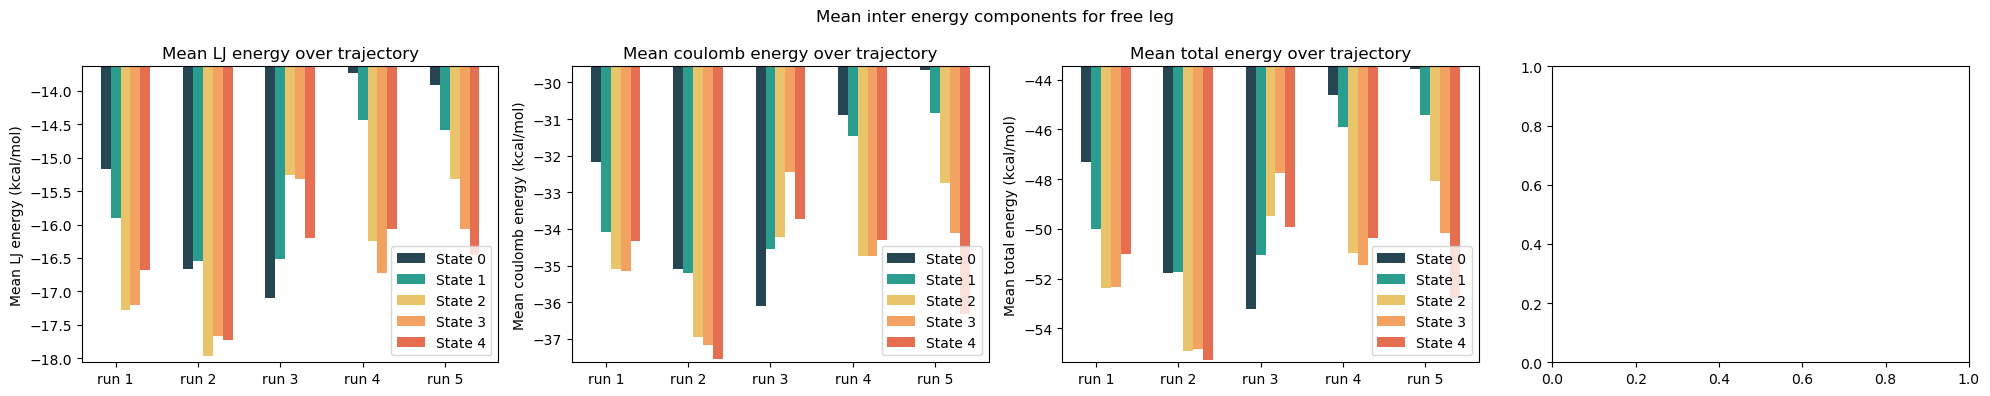

In [9]:
plot_av_energy_components(energy_dfs_free_inter, inter_components, "inter", "free", average_over_runs=False)

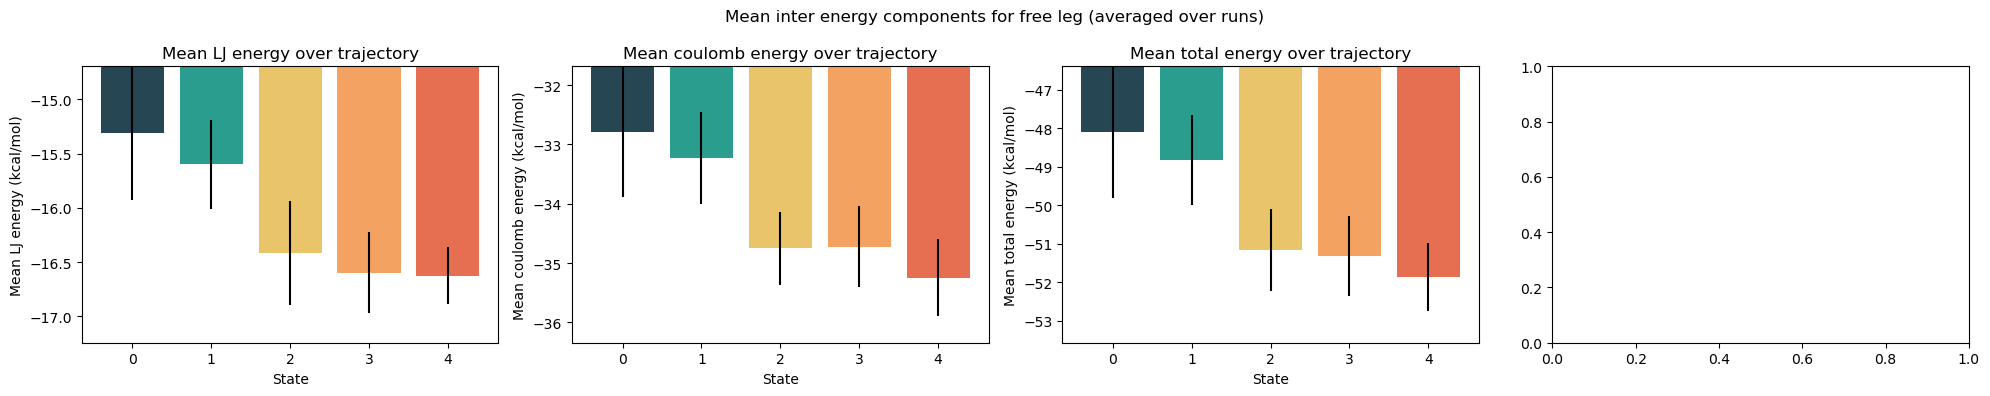

In [10]:
plot_av_energy_components(energy_dfs_free_inter, inter_components, "inter", "free", average_over_runs=True)

#### Bound Leg - Intramolecular Energies

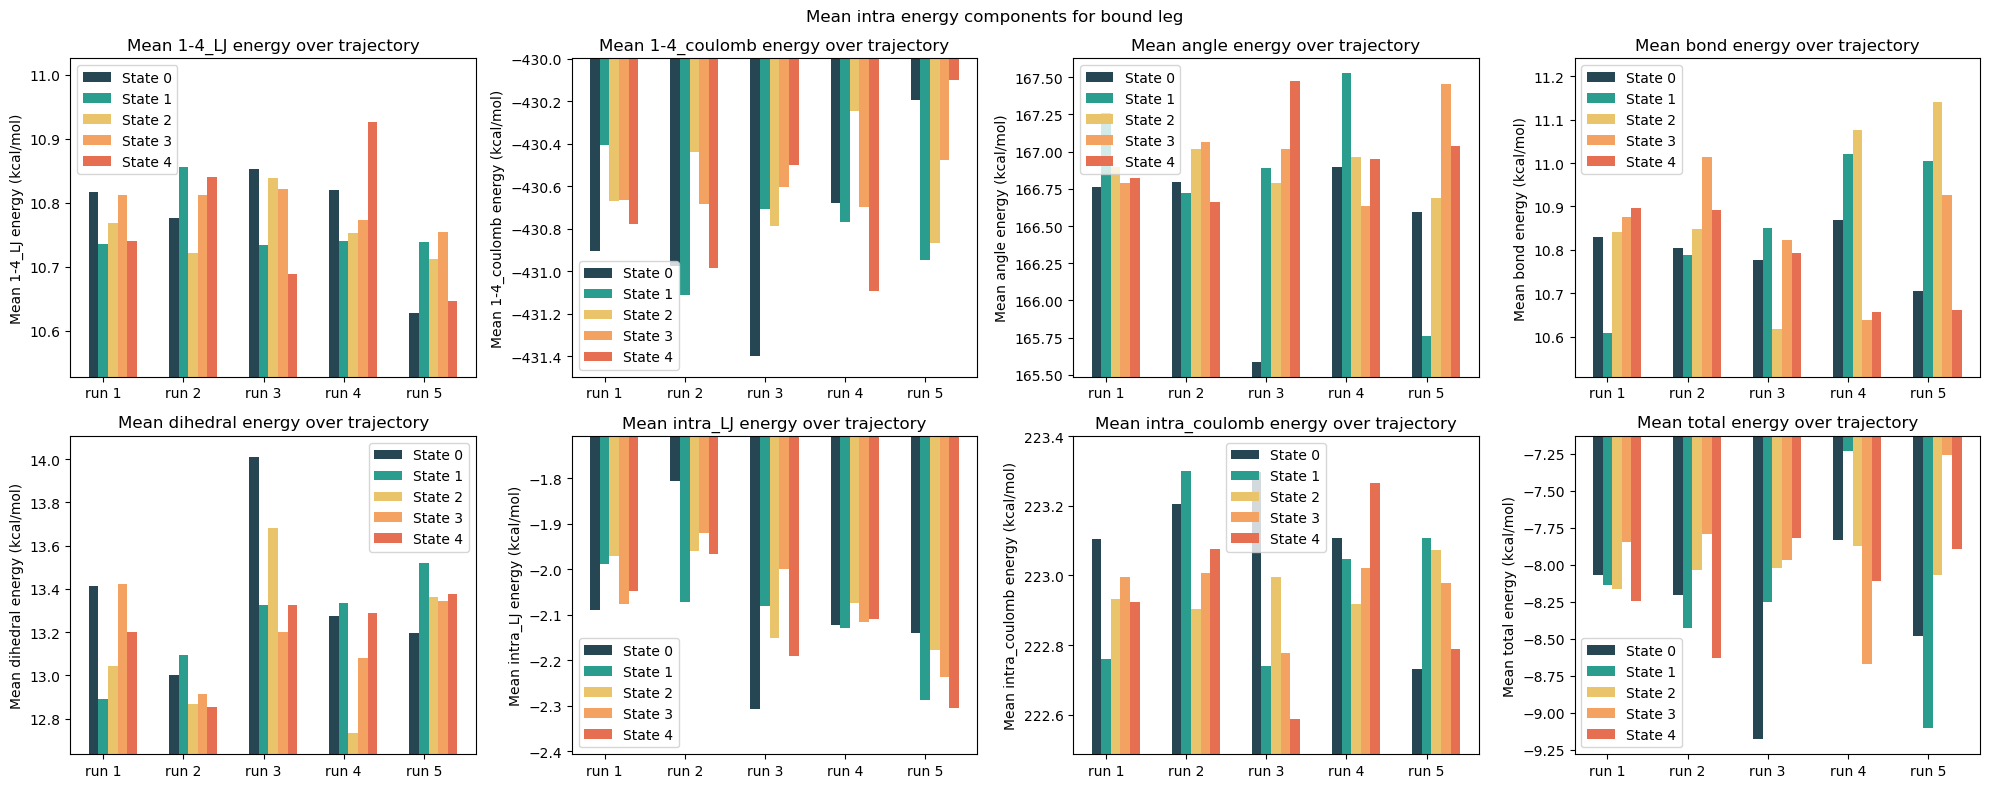

In [11]:
plot_av_energy_components(energy_dfs_bound_intra, intra_components, "intra", "bound", average_over_runs=False)

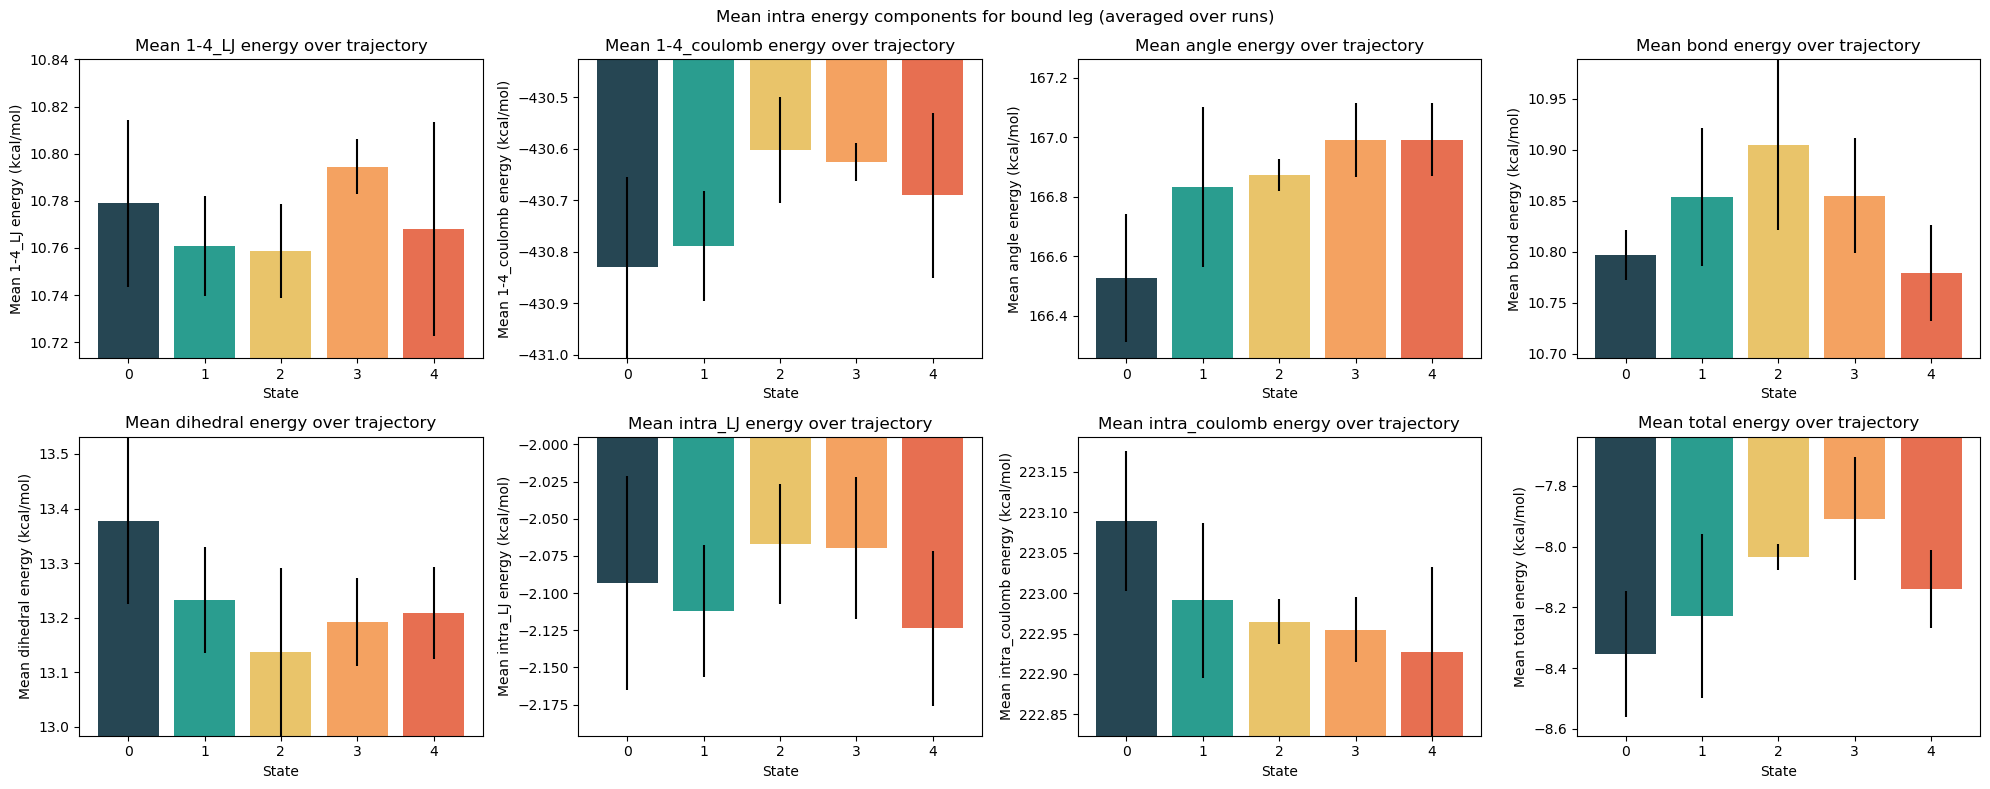

In [12]:
plot_av_energy_components(energy_dfs_bound_intra, intra_components, "intra", "bound", average_over_runs=True)

#### Bound Leg - Intermolecular Energies

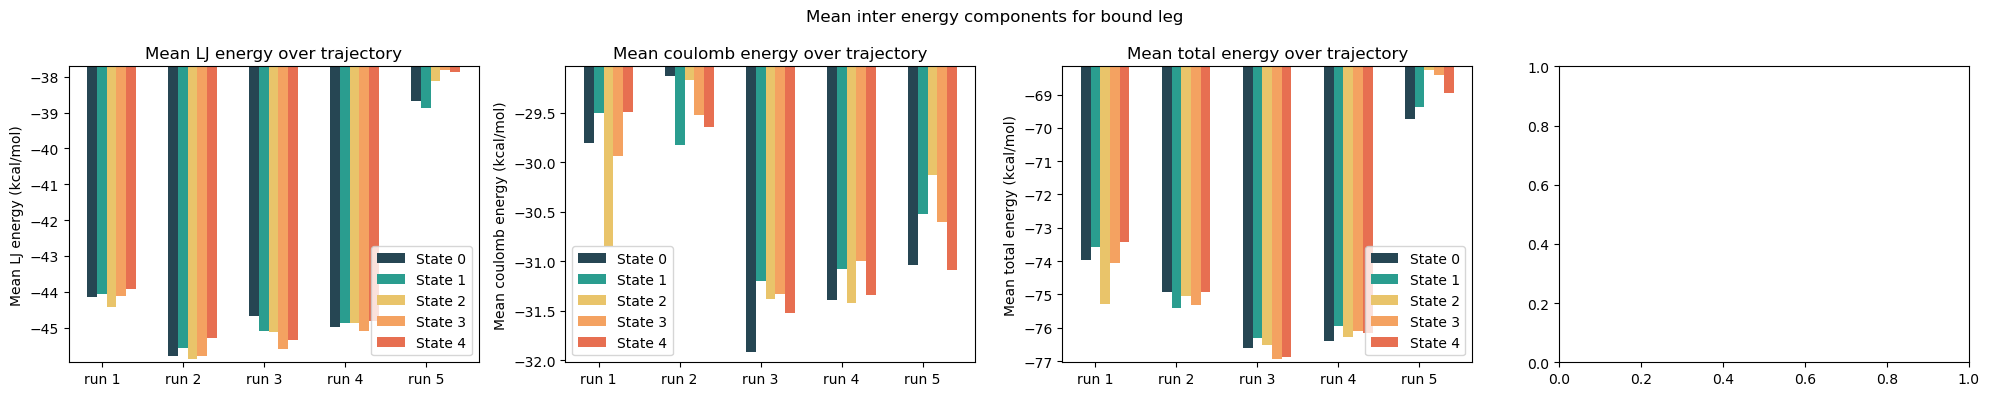

In [13]:
plot_av_energy_components(energy_dfs_bound_inter, inter_components, "inter", "bound", average_over_runs=False)

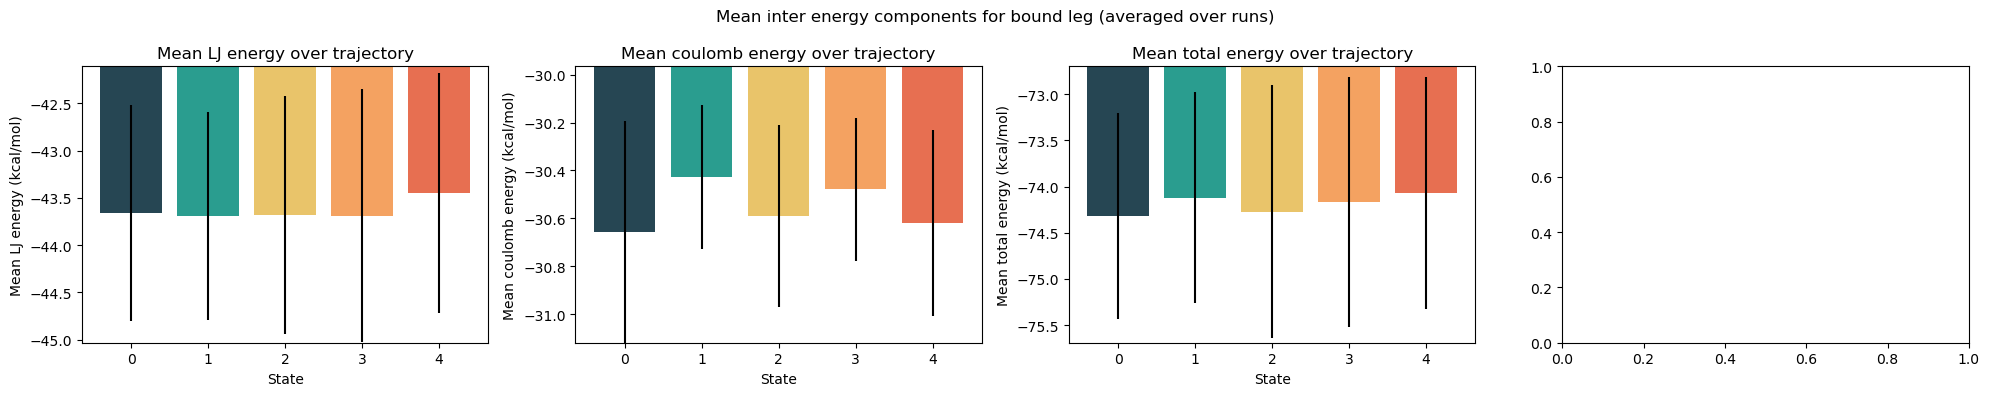

In [14]:
plot_av_energy_components(energy_dfs_bound_inter, inter_components, "inter", "bound", average_over_runs=True)